In [15]:
import torch
import numpy as np

# List of words
word_list = ["apple", "banana", "orange", "grape"]

# Word embeddings (vector representations) for each word
word_embeddings_a = {
    "apple": np.array([0.2, 0.5, -0.1]),
    "banana": np.array([0.8, 0.3, 0.2]),
    "orange": np.array([0.6, -0.4, 0.9]),
    "grape": np.array([0.1, 0.7, 0.5])
}

word_embeddings_r = {
    "apple": np.array([0.4, 0.3, -0.2]),
    "banana": np.array([0.7, 0.1, 0.3]),
    "orange": np.array([0.3, -0.6, 0.8]),
    "grape": np.array([0.2, 0.8, 0.4])
}

# Ground truth similarity labels
labels = np.array([[1.0, 0.5, 0.2, 0.3],
                   [0.5, 1.0, 0.4, 0.1],
                   [0.2, 0.4, 1.0, 0.6],
                   [0.3, 0.1, 0.6, 1.0]])

# Convert labels to PyTorch tensor
labels_tensor = torch.tensor(labels)

# Compute similarity using the provided formula
similarity_matrix = np.zeros((len(word_list), len(word_list)))
for i in range(len(word_list)):
    for j in range(len(word_list)):
        lhs_a = torch.tensor(word_embeddings_a[word_list[i]]).unsqueeze(0)
        rhs_a = torch.tensor(word_embeddings_a[word_list[j]]).unsqueeze(0)
        lhs_r = torch.tensor(word_embeddings_r[word_list[i]]).unsqueeze(0)
        rhs_r = torch.tensor(word_embeddings_r[word_list[j]]).unsqueeze(0)

        a_sim = torch.matmul(lhs_a, rhs_a.T).sum(1)
        r_sim = torch.matmul(lhs_r, rhs_r.T).sum(1)
        sim = a_sim - r_sim

        if i != j:
            similarity_matrix[i, j] = sim.item()

# Convert similarity matrix to PyTorch tensor
similarity_tensor = torch.tensor(similarity_matrix)
print(similarity_tensor)

# Exclude diagonal elements from the loss calculation
loss_mask = torch.ones_like(labels_tensor)
torch.diagonal(loss_mask).fill_(0)
loss = torch.nn.MSELoss()(labels_tensor, similarity_tensor * loss_mask)

print("Loss:", loss.item())


tensor([[0.0000, 0.0400, 0.0500, 0.0800],
        [0.0400, 0.0000, 0.1500, 0.0500],
        [0.0500, 0.1500, 0.0000, 0.3300],
        [0.0800, 0.0500, 0.3300, 0.0000]], dtype=torch.float64)
Loss: 0.30255


In [2]:
import numpy as np
from numpy.linalg import eig

def minimal_ar_decomposition(M_hat, low_rank, k=None):
    """
    Compute minimal AR decomposition for the input matrix M_hat.
    M_hat: Input matrix
    low_rank: Boolean flag indicating if low rank approximation is required
    k: The desired rank when low_rank is set to True
    """

    # Step 1: Compute the eigendecomposition of M_hat
    D, Q_prime = eig(M_hat)

    # If a low rank approximation is desired
    if low_rank:
        # Step 2: Truncate the n-k smallest in absolute value eigenvalues to 0
        smallest_eigenvalues_indices = np.abs(D).argsort()[:-k]  
        D[smallest_eigenvalues_indices] = 0  

    # Step 3: Split the eigenvalues into strictly positive and strictly negative
    D_pos = D[D > 0]
    D_neg = D[D < 0]

    # Step 4: Select the corresponding eigenvectors
    Q_pos = Q_prime[:, D > 0]
    Q_neg = Q_prime[:, D < 0]

    # Step 5: Construct matrices A and R
    A = Q_pos @ np.sqrt(np.diag(D_pos))
    R = Q_neg @ np.sqrt(np.diag(-D_neg))

    return D, Q_prime, D_pos, D_neg, Q_pos, Q_neg, A, R


# Define the matrix M_hat
M_hat = np.array([[2, -1, 0], 
                  [-1, 2, -1], 
                  [0, -1, 2]])

# Set low rank flag to False
low_rank = False

# Call the minimal_ar_decomposition function
D, Q_prime, D_pos, D_neg, Q_pos, Q_neg, A, R = minimal_ar_decomposition(M_hat, low_rank)

# Print results
print("D:", D)
print("Q_prime:", Q_prime)
print("D_pos:", D_pos)
print("D_neg:", D_neg)
print("Q_pos:", Q_pos)
print("Q_neg:", Q_neg)
print("A:", A)
print("R:", R)

# Rows of A and R
for i in range(A.shape[0]):
    print(f"a_{i}: ", A[i, :])
    print(f"r_{i}: ", R[i, :])


D: [3.41421356 2.         0.58578644]
Q_prime: [[-5.00000000e-01 -7.07106781e-01  5.00000000e-01]
 [ 7.07106781e-01  4.19803081e-16  7.07106781e-01]
 [-5.00000000e-01  7.07106781e-01  5.00000000e-01]]
D_pos: [3.41421356 2.         0.58578644]
D_neg: []
Q_pos: [[-5.00000000e-01 -7.07106781e-01  5.00000000e-01]
 [ 7.07106781e-01  4.19803081e-16  7.07106781e-01]
 [-5.00000000e-01  7.07106781e-01  5.00000000e-01]]
Q_neg: []
A: [[-9.23879533e-01 -1.00000000e+00  3.82683432e-01]
 [ 1.30656296e+00  5.93691211e-16  5.41196100e-01]
 [-9.23879533e-01  1.00000000e+00  3.82683432e-01]]
R: []
a_0:  [-0.92387953 -1.          0.38268343]
r_0:  []
a_1:  [1.30656296e+00 5.93691211e-16 5.41196100e-01]
r_1:  []
a_2:  [-0.92387953  1.          0.38268343]
r_2:  []


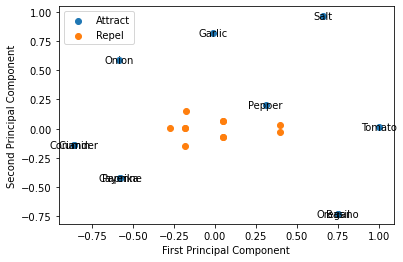

In [3]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Synthetic recipe dataset
recipes = {
    'Recipe 1': ['Tomato', 'Onion', 'Garlic', 'Salt', 'Pepper'],
    'Recipe 2': ['Tomato', 'Garlic', 'Basil', 'Salt', 'Oregano'],
    'Recipe 3': ['Onion', 'Garlic', 'Salt', 'Cumin', 'Coriander'],
    'Recipe 4': ['Garlic', 'Paprika', 'Salt', 'Pepper', 'Cayenne'],
    'Recipe 5': ['Tomato', 'Salt', 'Pepper', 'Basil', 'Oregano'],
}

# Constructing the adjacency matrix
ingredients = sorted(set([ingredient for recipe in recipes.values() for ingredient in recipe]))
N = len(ingredients)

adj_matrix = np.zeros((N, N))
for recipe in recipes.values():
    for i, ing1 in enumerate(recipe):
        for j, ing2 in enumerate(recipe):
            if i != j:
                adj_matrix[ingredients.index(ing1)][ingredients.index(ing2)] += 1

# Solve the nuclear norm minimization problem
M = cp.Variable((N, N), symmetric=True)
constraints = [M[i, j] == adj_matrix[i, j] for i in range(N) for j in range(N) if i != j]
problem = cp.Problem(cp.Minimize(cp.norm(M, "nuc")), constraints)
problem.solve()

M_hat = M.value

# Compute the eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(M_hat)

# Separate negative and positive eigenvalues/eigenvectors
negative_indices = eigenvalues < 0
positive_indices = eigenvalues > 0

D_negative = np.diag(np.abs(eigenvalues[negative_indices]))
D_positive = np.diag(eigenvalues[positive_indices])

Q_negative = eigenvectors[:, negative_indices]
Q_positive = eigenvectors[:, positive_indices]

# Define A and R
A = np.dot(Q_positive, np.sqrt(D_positive))
R = np.dot(Q_negative, np.sqrt(D_negative))

# Visualize the embeddings
pca = PCA(n_components=2)

A_pca = pca.fit_transform(A)
R_pca = pca.fit_transform(R)

plt.scatter(A_pca[:, 0], A_pca[:, 1], label='Attract')
plt.scatter(R_pca[:, 0], R_pca[:, 1], label='Repel')

# Add labels to the scatter plot
for i, ingredient in enumerate(ingredients):
    plt.text(A_pca[i, 0], A_pca[i, 1], ingredient, ha='center', va='center', color='black')

# Add axis labels
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.legend()
plt.show()


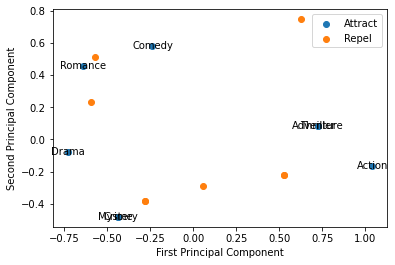

In [5]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Movie dataset
movies = {
    'Movie 1': ['Action', 'Thriller', 'Adventure'],
    'Movie 2': ['Comedy', 'Romance'],
    'Movie 3': ['Drama', 'Romance'],
    'Movie 4': ['Action', 'Thriller'],
    'Movie 5': ['Comedy', 'Adventure'],
    'Movie 6': ['Drama', 'Crime'],
    'Movie 7': ['Action', 'Adventure'],
    'Movie 8': ['Comedy', 'Drama'],
    'Movie 9': ['Drama', 'Mystery'],
    'Movie 10': ['Comedy', 'Thriller'],
}

# Constructing the adjacency matrix
genres = sorted(set([genre for movie in movies.values() for genre in movie]))
N = len(genres)

adj_matrix = np.zeros((N, N))
for movie in movies.values():
    for i, genre1 in enumerate(movie):
        for j, genre2 in enumerate(movie):
            if i != j:
                adj_matrix[genres.index(genre1)][genres.index(genre2)] += 1

# Solve the nuclear norm minimization problem
M = cp.Variable((N, N), symmetric=True)
constraints = [M[i, j] == adj_matrix[i, j] for i in range(N) for j in range(N) if i != j]
problem = cp.Problem(cp.Minimize(cp.norm(M, "nuc")), constraints)
problem.solve()

M_hat = M.value

# Compute the eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(M_hat)

# Separate negative and positive eigenvalues/eigenvectors
negative_indices = eigenvalues < 0
positive_indices = eigenvalues > 0

D_negative = np.diag(np.abs(eigenvalues[negative_indices]))
D_positive = np.diag(eigenvalues[positive_indices])

Q_negative = eigenvectors[:, negative_indices]
Q_positive = eigenvectors[:, positive_indices]

# Define A and R
A = np.dot(Q_positive, np.sqrt(D_positive))
R = np.dot(Q_negative, np.sqrt(D_negative))

# Visualize the embeddings
pca = PCA(n_components=2)

A_pca = pca.fit_transform(A)
R_pca = pca.fit_transform(R)

plt.scatter(A_pca[:, 0], A_pca[:, 1], label='Attract')
plt.scatter(R_pca[:, 0], R_pca[:, 1], label='Repel')

# Add labels to the scatter plot
for i, genre in enumerate(genres):
    plt.text(A_pca[i, 0], A_pca[i, 1], genre, ha='center', va='center', color='black')

# Add axis labels
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.legend()
plt.show()


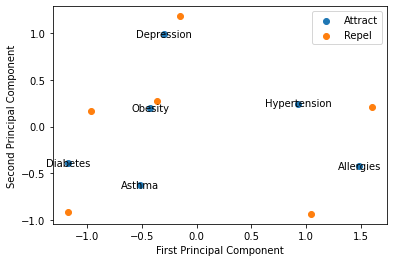

In [9]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# EHR data
ehr_data = {
    'Patient 1': ['Diabetes', 'Hypertension', 'Obesity'],
    'Patient 2': ['Asthma', 'Allergies'],
    'Patient 3': ['Hypertension', 'Obesity'],
    'Patient 4': ['Diabetes', 'Hypertension', 'Depression'],
    'Patient 5': ['Asthma', 'Obesity', 'Depression'],
    'Patient 6': ['Diabetes', 'Obesity', 'Depression'],
    'Patient 7': ['Hypertension', 'Allergies'],
    'Patient 8': ['Diabetes', 'Asthma', 'Depression'],
    'Patient 9': ['Hypertension', 'Obesity', 'Depression'],
    'Patient 10': ['Diabetes', 'Asthma'],
    'Patient 11': ['Asthma', 'Allergies', 'Depression'],
    'Patient 12': ['Diabetes', 'Obesity'],
    'Patient 13': ['Hypertension', 'Allergies', 'Depression'],
    'Patient 14': ['Diabetes', 'Asthma', 'Obesity', 'Depression'],
    'Patient 15': ['Hypertension', 'Obesity'],
    'Patient 16': ['Diabetes', 'Asthma', 'Depression'],
    'Patient 17': ['Hypertension', 'Obesity', 'Depression'],
    'Patient 18': ['Diabetes', 'Asthma', 'Obesity', 'Depression'],
    'Patient 19': ['Hypertension', 'Allergies', 'Depression'],
    'Patient 20': ['Diabetes', 'Asthma', 'Obesity'],
}

# Constructing the adjacency matrix
# Based on the co-occurrence of medical conditions across patients
conditions = sorted(set([condition for patient in ehr_data.values() for condition in patient]))
N = len(conditions)

adj_matrix = np.zeros((N, N))
for patient in ehr_data.values():
    for i, condition1 in enumerate(patient):
        for j, condition2 in enumerate(patient):
            if i != j:
                adj_matrix[conditions.index(condition1)][conditions.index(condition2)] += 1

# Solve the nuclear norm minimization problem
M = cp.Variable((N, N), symmetric=True)
constraints = [M[i, j] == adj_matrix[i, j] for i in range(N) for j in range(N) if i != j]
problem = cp.Problem(cp.Minimize(cp.norm(M, "nuc")), constraints)
problem.solve()

M_hat = M.value

# Compute the eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(M_hat)

# Separate negative and positive eigenvalues/eigenvectors
negative_indices = eigenvalues < 0
positive_indices = eigenvalues > 0

D_negative = np.diag(np.abs(eigenvalues[negative_indices]))
D_positive = np.diag(eigenvalues[positive_indices])

Q_negative = eigenvectors[:, negative_indices]
Q_positive = eigenvectors[:, positive_indices]

# Define A and R
A = np.dot(Q_positive, np.sqrt(D_positive))
R = np.dot(Q_negative, np.sqrt(D_negative))

# Visualize the embeddings
pca = PCA(n_components=2)


A_pca = pca.fit_transform(A)
R_pca = pca.fit_transform(R)

plt.scatter(A_pca[:, 0], A_pca[:, 1], label='Attract')
plt.scatter(R_pca[:, 0], R_pca[:, 1], label='Repel')

# Add labels to the scatter plot
for i, condition in enumerate(conditions):
    plt.text(A_pca[i, 0], A_pca[i, 1], condition, ha='center', va='center', color='black')

# Add axis labels
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.legend()
plt.show()



In [14]:
import cvxpy as cp
import numpy as np

# EHR data
ehr_data = {
    'Patient 1': ['Diabetes', 'Hypertension', 'Obesity'],
    'Patient 2': ['Asthma', 'Allergies'],
    'Patient 3': ['Hypertension', 'Obesity'],
    'Patient 4': ['Diabetes', 'Hypertension', 'Depression'],
    'Patient 5': ['Asthma', 'Obesity', 'Depression'],
    'Patient 6': ['Diabetes', 'Obesity', 'Depression'],
    'Patient 7': ['Hypertension', 'Allergies'],
    'Patient 8': ['Diabetes', 'Asthma', 'Depression'],
    'Patient 9': ['Hypertension', 'Obesity', 'Depression'],
    'Patient 10': ['Diabetes', 'Asthma'],
}

# Constructing the adjacency matrix
conditions = sorted(set([condition for patient in ehr_data.values() for condition in patient]))
N = len(conditions)

adj_matrix = np.zeros((N, N))
for patient in ehr_data.values():
    for i, condition1 in enumerate(patient):
        for j, condition2 in enumerate(patient):
            if i != j:
                adj_matrix[conditions.index(condition1)][conditions.index(condition2)] += 1

# Solve the nuclear norm minimization problem
M = cp.Variable((N, N), symmetric=True)
constraints = [M[i, j] == adj_matrix[i, j] for i in range(N) for j in range(N) if i != j]
problem = cp.Problem(cp.Minimize(cp.norm(M, "nuc")), constraints)
problem.solve()

# Print the co-occurrence matrix
print("Co-occurrence Matrix:")
for i in range(N):
    for j in range(N):
        print(int(adj_matrix[i][j]), end=" ")
    print()

# Print the nuclear norm minimization value
print("Nuclear Norm Minimization:", problem.value)


Co-occurrence Matrix:
0 1 0 0 1 0 
1 0 2 2 0 1 
0 2 0 3 2 3 
0 2 3 0 2 2 
1 0 2 2 0 3 
0 1 3 2 3 0 
Nuclear Norm Minimization: 16.071816437371975
